In [106]:
#import necessary libraries
import traceback
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math  
#draw a random graph using networkx module
G=nx.barabasi_albert_graph(100,3) 


In [83]:
#function to simulate the behavior of LND algorithm
def pay_pcn(source , destination  , money):
    global pcn_congestion
    failed=0
    G_copy=G.copy()
    try:
        #sender search the shortest path through which it can send money 
        shortest_path=nx.dijkstra_path(G_copy, source , destination) 
        while(money_matrix[shortest_path[0],shortest_path[1]]<money):
                G_copy.remove_edge(shortest_path[0],shortest_path[1])
                shortest_path=nx.dijkstra_path(G_copy, source , destination) #sender know its own channel balance search the shortest which have enough balance in his channel
        l=len(shortest_path)-1
        i=0
        while(i<l):
            pcn_congestion+=1
            #check if all channels have enough balance
            if(money_matrix[shortest_path[i],shortest_path[i+1]] < money) :
#                 print("%%%%%-----PAYMENT_____FAILED-------%%%%%")
                
                failed=1
                break
            i+=1
        i=0
        #if have enough balance ,send this money
        if(failed==0):
            while(i<l):
                money_matrix[shortest_path[i],shortest_path[i+1]] -= money 
                money_matrix[shortest_path[i+1],shortest_path[i]] += money 
                i+=1
#             print("****-----PAYMENT_____SUCCESFULL------***")
    except:
        failed=1
        return failed
        
    return failed

In [84]:
#funtion to simulate the behavior of boomerang algorithm
def pay_boomerang(source,destination,money):
    G_copy=G.copy()
    global boomerang_congestion #measures the congestion level
    
    initial_destional_money=0
    
    remaining=boomerang_redundancy_rate*money
    global money_matrix  #matrix of the channel balances
    global money_matrix_copy # make a copy to revert if unsuccesfull
    
    for j in range(100):
        initial_destional_money+=money_matrix_copy[destination][j]   #keeping the fund destination possesses before payment in this variable
    paths=nx.shortest_simple_paths(G_copy, source, destination)  # paths keeps all the shortest path from source to destination
    
    #try each path and send unit money from each path
    for path in paths:
            if(remaining==0):
                break  # if no more money is need to be sent, break the loop
            
            l=len(path)-1  # length of the path
            failed=0
            i=0
            #check out balances in each channel of each path 
            while(i<l):
                boomerang_congestion+=1
                if(money_matrix_copy[path[i],path[i+1]] < 1) :
                    
                    failed=1
                    break # if some channel does not contain enough money , ignore this path
                    
                i+=1
            #keeping the fund of destination after payment has been sent
            final_destional_money=0
            for k in range(100):
                final_destional_money+=money_matrix_copy[destination][k]
            
            i=0
            #check if receiver already got the required amount, revert the redundant amount
            if(failed==0 and final_destional_money-initial_destional_money!=money):
                while(i<l):
                    money_matrix_copy[path[i],path[i+1]] -= 1
                    money_matrix_copy[path[i+1],path[i]] +=1 
                    i+=1
            
            remaining-=1  # update the remaining balance after each succesful payment

            
        
        
    

In [85]:
#simulation of the asap algorithm
def pay_asap(source,destination,money,original_money):
    G_copy=G.copy()
    global money_matrix
    global money_matrix_copy
    money_matrix_copy=money_matrix.copy()
    prev_sum=0 #destion money before payment
    for i in range(0,100):
        prev_sum+=money_matrix_copy[i,destination]
    #call each channel to send money recursively
    sucess=pay_recur(source,destination,money,G_copy,nx.dijkstra_path(G_copy, source , destination),original_money)
    next_sum=0 #destination money after payment
    for i in range(0,100):
        next_sum+=money_matrix_copy[i,destination]
    if(sucess):
        #for succesfull payment update the money_matrix
#         print("****-----PAYMENT_____SUCCESFULL------***")
        money_matrix=money_matrix_copy
        return 1
    else:
#         print("%%%%%-----PAYMENT_____FAILED-------%%%%%")
        return 0
 

In [86]:
def pay_recur(source,destination,money,G_copy,path,original_money):
    global congestion  #update the congestion

    remaining_balance=money
    assert(remaining_balance>=beta*original_money)  # check whether split has gone below threshold
    sucess=1
    
    if(len(path)==1):
        sucess=1  # if payment has reached the end of the path, it is successful
    
    else:
        try:
            congestion+=1
            if(money_matrix_copy[path[0],path[1]]>= remaining_balance): #check if first path has enough enough
                    
                    money_matrix_copy[path[0],path[1]]-=remaining_balance
                    money_matrix_copy[path[1],path[0]]+=remaining_balance
                    #update the money_matric_copy and congestion lebel
                    
                    
                    path.pop(0)
                    #if have enough money , ask the sender to send the money
                    sucess=pay_recur(path[0],destination,remaining_balance,G_copy,path,original_money)
                    
                    #thus remaining balance for this node is 0
                    remaining_balance=0
                    
                    #check if further nodes succesfully send this money
                    assert(sucess==1)
            else:
                #if channel does not have enough balance split the money
                sucess=split(path[0],destination,remaining_balance,G_copy,path,original_money)                   
        except:
            sucess=0
            
    return (bool(sucess))

In [87]:
#function for spliting the money
def split(source , destination , money ,G_copy ,  path,original_money):
  
    sucess=1
    path_copy=path.copy()
    try:
        G_temp=G_copy.copy()
        remaining_balance = money
       
        
        #check if balance does not go below threshold split
        while(remaining_balance >= (beta*original_money)):
            
            if(G_temp.has_edge(path_copy[0],path_copy[1]) and money_matrix_copy[path_copy[0],path_copy[1]]<=0):
                G_temp.remove_edge(path_copy[0],path_copy[1])
                
                #if some path has 0 balance remove the path temporarily for the current transation
                #then find a new path
                path_copy=nx.dijkstra_path(G_temp, path_copy[0] , destination)
                
                
                continue
            else:
                
                
                #take alpha amount of money from this channel and send through this path
                if( ( 
                    fund= math.ceil(alpha* money_matrix_copy[path_copy[0],path_copy[1]])
                    #take alpha amount of money from this path in variable fund
                    
                    #send fund through this path
                    sucess=pay_recur(path_copy[0],destination,fund,G_temp,path_copy.copy(),original_money)
                    assert(sucess==1)
                    
                    #update the balance for this node
                    
                    remaining_balance-=fund
            
                    #remove this path temporarily for this transaction so that path does not make loop
                    G_temp.remove_edge(path_copy[0],path_copy[1])
                    path_copy=nx.dijkstra_path(G_temp, path_copy[0] , destination)
                                      
        assert(remaining_balance==0)   # assert whether this node is able to send all the money by spliting and sending it through different paths   
    except:
        #any fault leads to failure
        sucess=0
    finally:
        
        return bool(sucess)

In [96]:
#---------SIMULATE THE LND-------#
alpha=float(input("Give a aplh"))
lambd=float(input("Select a value for lambba of exponential distribution of payment"))
print("LND RUNNING..........")

random.seed(0)

pcn_congestion=0
pcn_success_rate=0


for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(0,10)
# nx.draw_spring(G)  #uncomment if you want to visualize the graph topology
dtype = np.dtype([("weight", int)])
cost_matrix = nx.to_numpy_array(G, dtype=int)
g=G

for (u, v) in g.edges():
    g.edges[u,v]['weight'] = random.randint(10,20)
dtype = np.dtype([("weight", int)])
money_matrix = nx.to_numpy_array(g, dtype=int)

failure=0 #count the failures

for i in range(1000):
        source = random.randint(0,99)
        dest=random.randint(0,99)
        while(dest==source):
            dest=random.randint(0,99)
        money=math.ceil(random.expovariate(lambd))+1
        failed=pay_pcn(source,dest,money)

        if(failed==1):
            failure+=1
pcn_success_rate=(1000-failure)/10

print("LND SIMULATION COMPLETED SUCCESFULLY")
print("LND SUCCESS PERCENTAGE IS : ",  pcn_success_rate)

print("LND CONGESTION LEVEL IS : ", pcn_congestion/100)



#---------SIMULATE THE Bommerang-------# 
print("BOOMERANG RUNNING.....")
boomerang_redundancy_rate=int(input("Select a integer between 2 and 3"))
boomerang_congestion=0
boomerang_success_rate=0
random.seed(0)

#give random weights to the graph from a uniform distribution from (0,10)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(0,10)
    
# nx.draw_spring(G)

dtype = np.dtype([("weight", int)])


#assign the weights to a weight matrix
cost_matrix = nx.to_numpy_array(G, dtype=int)


g=G
#give channels random balances
for (u, v) in g.edges():
    g.edges[u,v]['weight'] = random.randint(10,20)
dtype = np.dtype([("weight", int)])
money_matrix = nx.to_numpy_array(g, dtype=int) #money_matrix is the channel money in each channel

money_matrix_copy=money_matrix.copy()         #make a copy to update it temporarily

count=0  #variable to count the successful payments
congestion=0  #variable to count the congestion levels

for i in range(1000): # for 1000 payments
        source = random.randint(0,99) # randomly generate a source
        
        dest=random.randint(0,99)  #randomly generate a destination
        while(dest==source):
            dest=random.randint(0,99)  #make sure that source and destination are not same

        money=math.ceil(random.expovariate(lambd))+1  #choose payment money to be transferred from a exponential distribution

        initial_destional_money=0
        for j in range(100):
            initial_destional_money+=money_matrix_copy[dest][j]
        
        pay_boomerang(source,dest,money)
        final_destional_money=0
        for k in range(100):
            final_destional_money+=money_matrix_copy[dest][k]   # line 33 to 41 make sure that receiver receiver receive the exact amout send by the sender
        
           
        failed=final_destional_money-initial_destional_money-money
        if(failed==0):
#             print("****-----PAYMENT_____SUCCESFULL------***")
            count+=1
print("SIMULATION OF BOOMERANG SUCCESSFULLT COMPLETED")
boomerang_success_rate=(count)/10
print("BOOMERANG SUCCESS PERCENTAGE :", boomerang_success_rate)
print("BOOMERANG CONGESTION LEVELS :", boomerang_congestion/100)





#------SIMULATION OF ASAP--------#
accuracy_rate=[]    #keep the accuracy rate for different values of alpha and beta
congestion_levels=[]  #keep the congestion levels for diffent values of alpha and beta
print("ASAP RUNNING......")
for j in range(5):
    congestion=0
    alpha=0.8
    beta=0.2 + (0.1*(j))
    temp=0
    random.seed(0)

    #code creating G here

    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(0,10)
#     nx.draw_spring(G)
    dtype = np.dtype([("weight", int)])
    cost_matrix = nx.to_numpy_array(G, dtype=int)
    g=G

    for (u, v) in g.edges():
        g.edges[u,v]['weight'] = random.randint(10,20)
    dtype = np.dtype([("weight", int)])
    money_matrix = nx.to_numpy_array(g, dtype=int)
    for i in range(1000):
        source = random.randint(0,99)
        dest=random.randint(0,99)
        while(dest==source):
            dest=random.randint(0,99)
        money=math.ceil(random.expovariate(lambd))+1
        failed=pay_asap(source,dest,money,money)
        if(failed==1):
            temp+=1
    accuracy_rate.append(temp/10)
    congestion_levels.append(congestion)
# congestion_levels=[x/10 for x in congestion_levels]    
print("SIMULATION OF ASAP SUCCESFULLY COMPLETED")

print("alpha = 0.8 ")
print("beta = 0.2")
print("ASAP SUCCESS PERCENTAGE" , accuracy_rate[1])
print("ASAP CONGESTION RATE" , congestion_levels[1]/100)



Give a aplh0.8
Select a value for lambba of exponential distribution of payment0.3
LND RUNNING..........
LND SIMULATION COMPLETED SUCCESFULLY
LND SUCCESS PERCENTAGE IS :  80.0
LND CONGESTION LEVEL IS :  25.12
BOOMERANG RUNNING.....
Select a integer between 2 and 33
SIMULATION OF BOOMERANG SUCCESSFULLT COMPLETED
BOOMERANG SUCCESS PERCENTAGE : 96.0
BOOMERANG CONGESTION LEVELS : 508.75
ASAP RUNNING......
SIMULATION OF ASAP SUCCESFULLY COMPLETED
alpha = 0.8 
beta = 0.2
ASAP SUCCESS PERCENTAGE 88.8
ASAP CONGESTION RATE 33.12


In [95]:
accuracy_rate

[94.4, 88.8, 84.4, 81.5, 78.5]

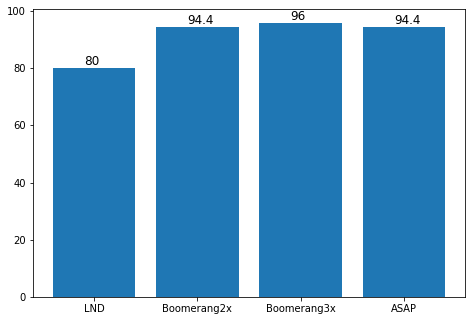

In [124]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
algos = ['LND', 'Boomerang2x', 'Boomerang3x', 'ASAP']
Success_rate = [80,94.4,96,94.4]
ax.bar(algos,Success_rate,)
for index,data in enumerate(Success_rate):
    plt.text(x=index-0.1 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=12))
plt.show()

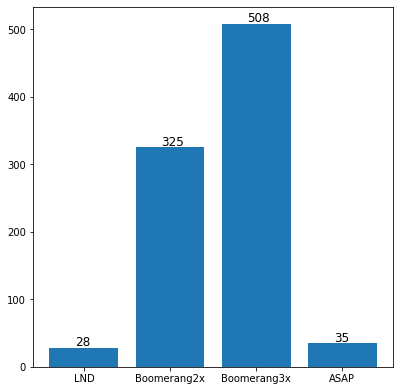

In [125]:
fig, ax = plt.subplots(figsize = (5,5))
ax = fig.add_axes([0,0,1,1])
algos = ['LND', 'Boomerang2x', 'Boomerang3x', 'ASAP']
Congestion_levels = [28,325,508,35]
ax.bar(algos,Congestion_levels)

for index,data in enumerate(Congestion_levels):
    plt.text(x=index-0.1 , y =data+3 , s=f"{data}" , fontdict=dict(fontsize=12))
# plt.tight_layout()
plt.savefig("Congestion_level.png")
plt.show()

In [105]:
pip install --upgrade matplotlib

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\acer\\anaconda3\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Users\acer\anaconda3\python.exe -m pip install --upgrade pip' command.
